In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import linalg

import mylib as my

# 09.A: Gradient-based SVMs
Gradient descent can also be used to implement support vector machines. Below are two implementations of the Pegasos algorithm which uses a gradient descent-approach to implement SVM's. This algorithm was proposed in 2010 in the following paper:

    Shalev-Shwartz, S., Singer, Y., Srebro, N. et al. Pegasos: primal estimated sub-gradient solver for SVM. Math. Program. 127, 3–30 (2011). https://doi.org/10.1007/s10107-010-0420-4

You can read this paper at https://link.springer.com/content/pdf/10.1007/s10107-010-0420-4.pdf

## Soft-margin Pegasos

This algorithm looks like the following. See the above paper for explanation and more details. This algorithm covers only updating the weight vector $\mathbf{w}$. There is a section in the paper that talks about adding the bias (intercept) term $b$.

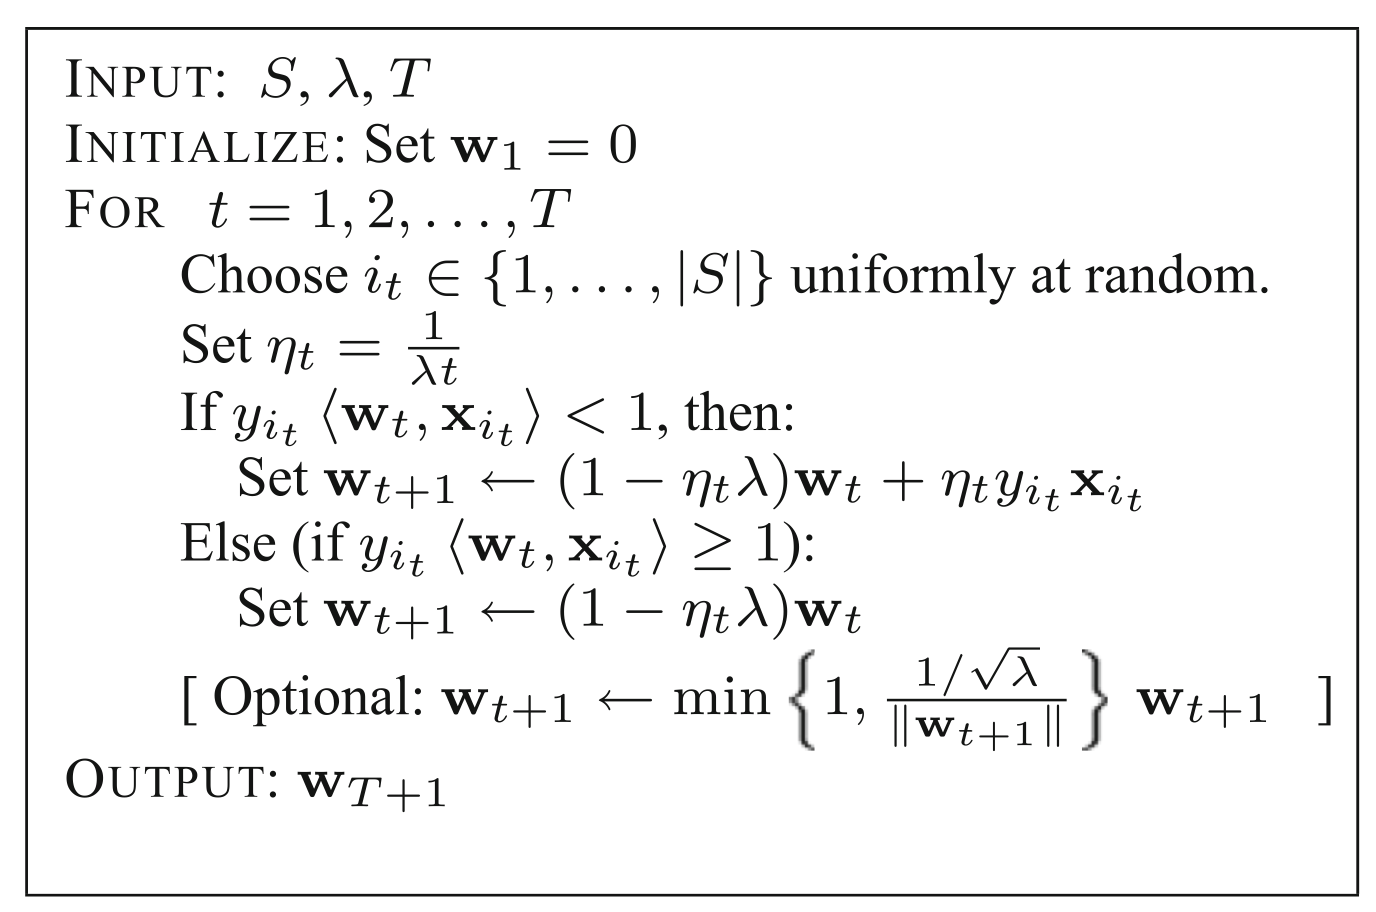

Notice that $\left\langle \mathbf{w},\mathbf{x}\right\rangle$ means the dot product of $\mathbf{w}$ and $\mathbf{x}$.

Here is an implementation of this algorithm.

In [2]:
class PegasosSVM:
    def __init__(self, lmbda=1, n_iters=1000):
        self.lmbda = lmbda
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        N, M = X.shape
        
        self.w = np.zeros(M)
        self.b = 0
        for t in range(1, self.n_iters + 1):
            i = np.random.randint(N)
            eta = 1/(self.lmbda * t)
            condition = y[i] * (np.dot(X[i], self.w) - self.b)
            if condition < 1:
                self.w = (1 - eta * self.lmbda) * self.w + eta * y[i] * X[i]
            else:
                self.w = (1 - eta * self.lmbda) * self.w
                self.b = self.b - eta * y[i]

    def predict(self, unseen):
        pred = self.w @ unseen.T - self.b
        return np.sign(pred)

Let's test it using the following simulated data:

In [3]:
n = 150
data = np.array([[3, 14],[10, 9]])
d0 = np.concatenate((data[0,0] + np.random.normal(loc=1, scale=2.8, size=(n, 1)), 
                data[0, 1] + np.random.normal(loc=1, scale=1.2, size=(n, 1)), np.zeros(n).reshape(n, 1)), axis= 1)

d1 = np.concatenate((data[1,0] + np.random.normal(loc=.5, scale=2.5, size=(n, 1)), 
                data[1, 1] + np.random.normal(loc=.5, scale=1, size=(n, 1)), np.ones(n).reshape(n, 1)), axis= 1)


d = np.concatenate((d0, d1), axis=0)
ds = my.DataSet(pd.DataFrame(d, columns=['x1', 'x2', 'y']), y=True)

# Chaning the output lable to -1 and +1
ds.examples.iloc[:, -1] = ds.examples.iloc[:, -1].apply(lambda x: -1 if x == 0 else 1)

Here is how this implementation performs on this data given 6 different values of the `n_iters` parameter, which is similar to but not exactly like `epochs`. 

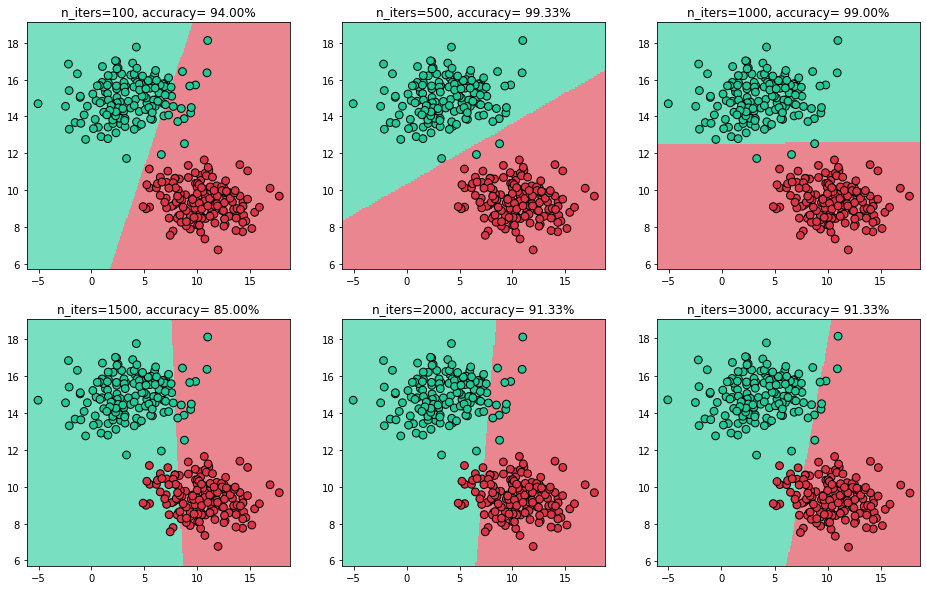

In [4]:
iters = [100, 500, 1000, 1500, 2000, 3000]
fig = plt.figure(figsize=(16,10))
axes = fig.subplots(2,3)
for i, it in enumerate(iters):
    svm = PegasosSVM(n_iters=it, lmbda=.01)
    svm.fit(ds.inputs, ds.target.flatten())

    cm = my.confusion_matrix(ds.target, svm.predict(ds.inputs))
    my.plot_decision_regions(ds.inputs, ds.target, svm, resolution=0.1, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f"n_iters={it}, accuracy={100 * np.trace(cm) / np.sum(cm): .2f}%")

## Kernelized Pegasos
For non-leaner data, there is need for a kernelized version of this algorithm. The above paper gives us such an algorithm.

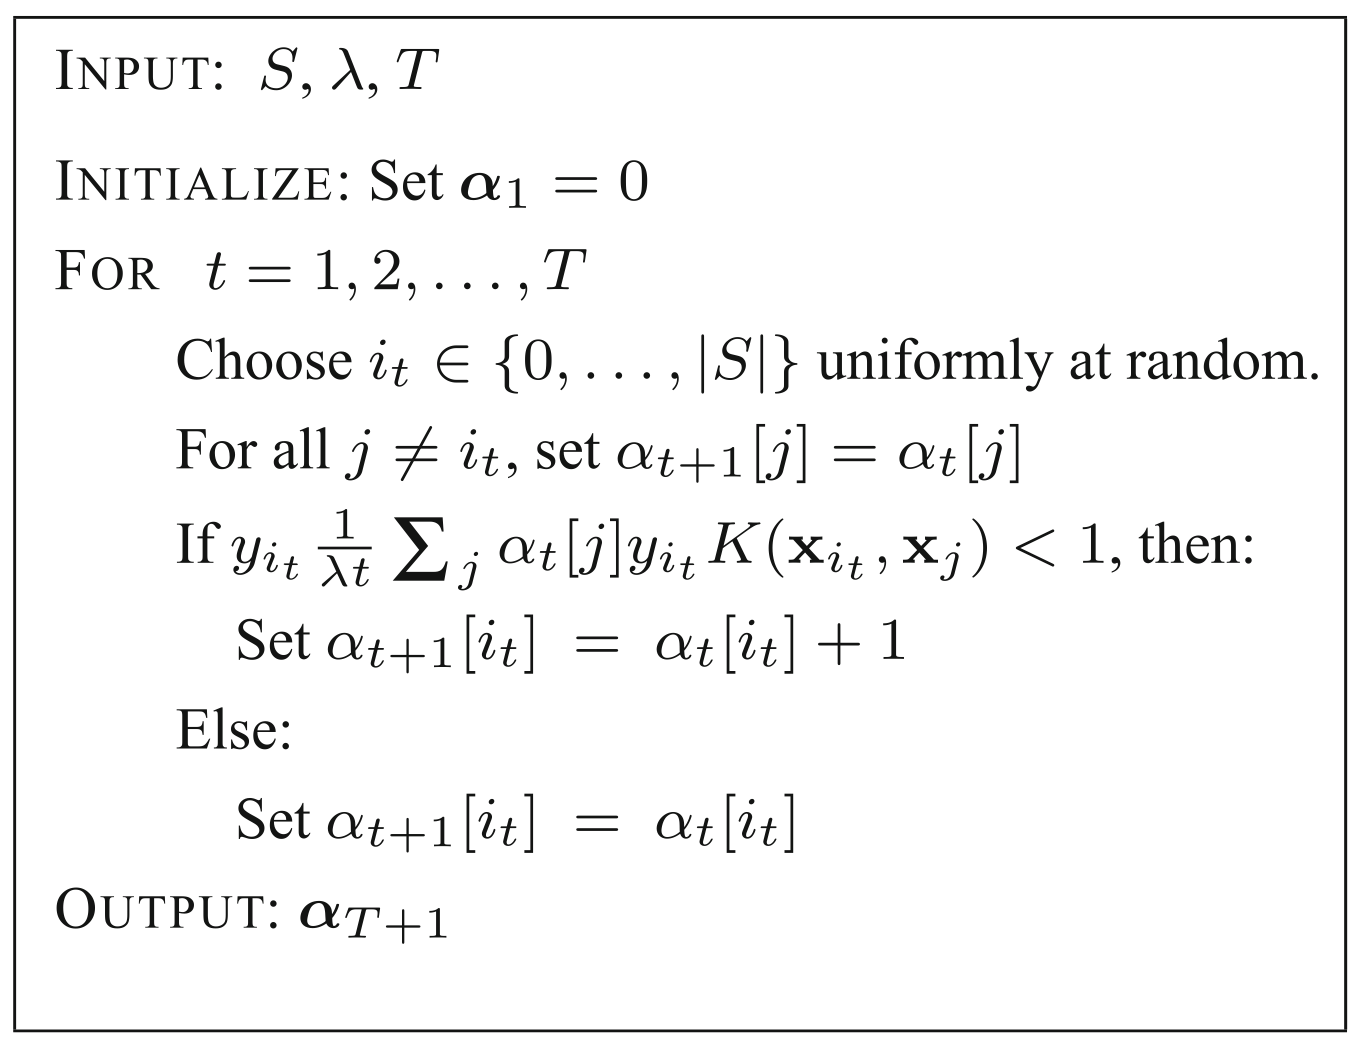

Below is an implementation of this algorithm with a default RBF kernel.

In [20]:
class KernelizedPegasosSVM:
    def __init__(self, ds, kernel=None, lmbda=0.01, gamma = 5, n_iters=1000):
        self.lmbda = lmbda
        self.gamma = gamma
        self.n_iters = n_iters
        self.a = None
        self.b = None
        self.X = ds.inputs
        self.y = ds.target.flatten().astype('float')
        self.kernel = kernel or (lambda x1, x2, gamma=gamma: np.exp(-gamma * np.linalg.norm(x1 - x2)**2))

    def fit(self):
        N, M = self.X.shape
        
        self.a = np.zeros(N)
        self.b = 0
        for t in range(1, self.n_iters + 1):
            i = np.random.randint(N)
            eta = 1/(self.lmbda * t)
            total_cond = 0
            for j in range(N):
                if i != j:
                    total_cond += self.y[i] * eta * self.a[j] * self.y[i] * self.kernel(self.X[i], self.X[j], self.gamma)
            if total_cond < 1:
                self.a[i] = self.a[i] + 1
            else:
                self.a[i] = self.a[i]
                self.b = self.b - eta * self.y[i]

    def predict(self, unseen):
        if unseen.ndim == 1:
            pred = [self.a[i] * self.y[i] * self.kernel(self.X[i], unseen, self.gamma) for i in range(len(self.y))]
            return np.sign(np.array(pred).sum())
        else:
            return np.array([self.predict(ex) for ex in unseen])

### CHALLENGE A

Test the `KernelizedPegasosSVM` implementation above using the simulated circular (using scikit's make_circles function) and moon (using scikit's make_moons function) data from the previous SVM notebook. 

In [6]:
# TODO

# 09.B: Dimensionality reduction

The goal here is to obtain a low-dimensional mapping of the feature space without losing two much information. For that we try to find a line, a plane, or a hyperplane to project the data onto.

We can do that in two ways:
* in a supervised way taking advantage of knowing what the actual outcomes are. We use the **Linear Discriminant Analysis (LDA)** to do that.
* in an unsupervised way with only the input data and not actual outcomes. We use **Principal Component Analysis (PCA)** for this.

These techniques are typically done for two main reasons:
* Data visualization by reducing the data to 2 or 3 dimensions
* Faster processing by reducing high-dimensional data to lower-dimensional data; for example 1000 to 100.

## Linear Discriminant Analysis (LDA)
This is a supervised dimensionality reduction technique by Ronald A. Fisher. Here we seek a new low-dimensional mapping of the input data that:

* maximizes the linear separability of classes
* minimizes the scatter of the examples within classes

Given a dataset with $N$ examples and $C$ classes, we start by measuring how examples within classes are scattered or spread out. For a single class $c$ with a mean $\mathbf{\mu}_c$, the within-class scatter is :

$$\mathbf{s}_c = \frac{1}{N}\sum_{i \in c} (\mathbf{x}_i - \mathbf{\mu}_c)(\mathbf{x}_i - \mathbf{\mu}_c)^T$$

And the total amount of within-class scatter is the weighted sum of $\mathbf{s}_c$ for all classes. That is:

$$\mathbf{S}_w = \sum_{c = 1}^C \frac{N_c}{N} \sum_{i \in c}(\mathbf{x}_i - \mathbf{\mu}_c)(\mathbf{x}_i - \mathbf{\mu}_c)^T = \sum_{c = 1}^C p_c \sum_{i \in c}(\mathbf{x}_i - \mathbf{\mu}_c)(\mathbf{x}_i - \mathbf{\mu}_c)^T$$

where $p_c = N_c / N$ is the probability of class $c$. For measuring the separability of the classes we use the between-class scatter which can be calculated as:

$$\mathbf{S}_b = \sum_{c = 1}^C (\mathbf{\mu}_c - \mathbf{\mu})(\mathbf{\mu}_c - \mathbf{\mu})^T$$

where $\mathbf{\mu}$ is the mean vector of all examples.

LDA tries to find the projection that maximizes the quantity $\mathbf{S}_b / \mathbf{S}_w$ which amounts to maximizing $\mathbf{S}_b$ normalized by $\mathbf{S}_w$. The quantity $\mathbf{S}_b / \mathbf{S}_w$ can be written as $\mathbf{S}_w^{-1} \mathbf{S}_b$.

The LDA works by finding the eigenvectors and eigenvalues of the matrix $\mathbf{S}_w^{-1} \mathbf{S}_b$, which are then used to linearly transform the data into low-dimensional spaces. We do that by sorting the eigenvectors decreasingly by the eigenvalues. We pick the first $k$ eigenvectors to transform the data.

Notice that the described LDA algorithm works only when $\mathbf{S}_w$ is invertible. If that is not the case, like in the MNIST example blew, we can use the pseudo-inverse instead as a workaround. When that happens, the eigenvalues and eigenvectors may have some complex values (with real and imaginary parts).

Let's implement this algorithm.

In [7]:
class LDA:
    def __init__(self, ndims):
        """ ndims: how many dimensions to reduce data to"""
        self.ndims = ndims
        
    def fit(self, dataset):
        X = dataset.inputs
        y = dataset.target.ravel()
        labels = np.unique(y)
        
        # Compute the mean vector of all examples
        mu = np.mean(X, axis=0)

        S_w = np.zeros((dataset.M, dataset.M))
        S_b = np.zeros((dataset.M, dataset.M))
        for c in labels:
            X_c = X[y == c]
            
            # Compute the mean vector of the c class examples
            mu_c = np.mean(X_c, axis=0)
            
            # Compute S_w
            p_c = len(X_c) / dataset.N
            S_w += p_c * (X_c - mu_c).T.dot((X_c - mu_c))

            # Compute S_b
            mu_diff = (mu_c - mu).reshape(dataset.M, 1)
            S_b += mu_diff.dot(mu_diff.T)

        # Compute the S_w-1 S_b matrix
        T = np.linalg.pinv(S_w).dot(S_b)

        # Compute the eigenvectors and eigenvalues of matrix T
        eig_vals, eig_vecs = np.linalg.eig(T)
        eig_vals = eig_vals.real # to do the use of pinv
        eig_vecs = eig_vecs.T
        
        # Sort the eigenvectors in decreesing eigenvalues
        sortedIndices = np.argsort(abs(eig_vals))[::-1]
        self.eig_vals = eig_vals[sortedIndices]
        self.eig_vecs = eig_vecs[sortedIndices]

    def transform(self, unseen):
        X = unseen.inputs
        # Project the data and return the results
        return np.dot(X, self.eig_vecs[0:self.ndims].T)

### Explained variance ratio
Given the number of discriminants (eigenvectors) $D$, we use the **explained variance ratio** to to calculate by how much a single discriminant $d$ contributes to the overall "discriminability". The **explained variance ratio** is defined as:
$$\text{explained variance ratio} = \frac{\lambda_d}{\sum_{i=1}^D \lambda_i}$$

### Testing LDA with the IRIS function

Here is an example using LDA to reduce the 4-dimensional ($x_1 - x_4$)  iris dataset to 2D (($z_1 - z_2$).

/Users/aalgahmi/opt/miniconda3/envs/ml/lib/python3.7/site-packages/matplotlib/collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


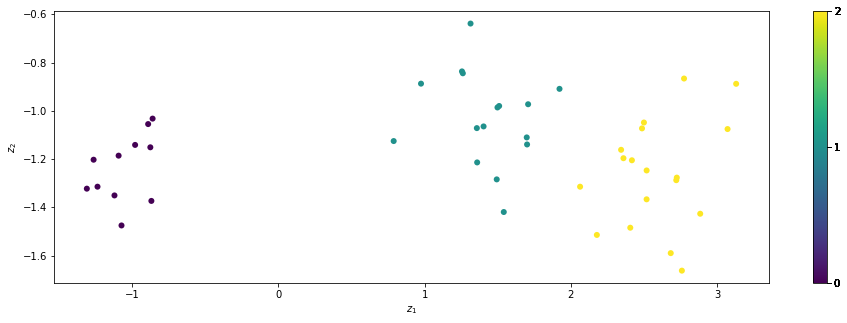

In [8]:
df = sns.load_dataset("iris")
df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: 0 if x == 'setosa' else (1 if x == 'versicolor' else 2))

ds = my.DataSet(df, y=True)
train, test = ds.train_test_split(test_portion=.3, shuffle=True)

lda = LDA(2)
lda.fit(train)

X_projected = lda.transform(test)
y = test.target.ravel()
fig = plt.figure(figsize=(16, 5))
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y, edgecolor='none')
cb = plt.colorbar()
cb.set_ticks(y)

plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.show()

Let's plot how much each discriminant (eigenvector) contributes to the total results.

Text(0.5, 0, 'Discriminant')

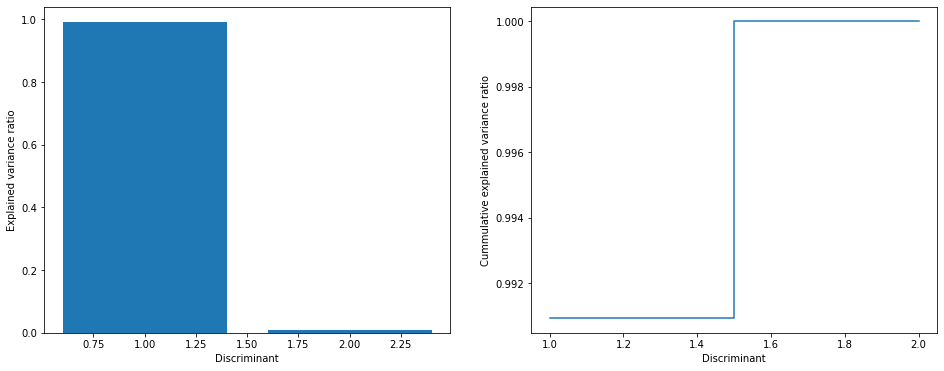

In [9]:
# Compute explained variance ratios; ignoring ratios < 0.001
expl_var = [i / lda.eig_vals.sum() for i in lda.eig_vals if i / lda.eig_vals.sum() >= 0.001] 
cum_expl_var = np.cumsum(expl_var)

fig = plt.figure(figsize=(16, 6))
ax1, ax2 = fig.subplots(1, 2)
ax1.bar(range(1, len(expl_var) + 1), expl_var, align='center')

ax1.set_ylabel('Explained variance ratio')
ax1.set_xlabel('Discriminant')

ax2.step(range(1, len(cum_expl_var) + 1), cum_expl_var, where='mid')

ax2.set_ylabel('Cummulative explained variance ratio')
ax2.set_xlabel('Discriminant')

### CHALLENGE B
Project the above data onto a one-dimensional space (a line) and plot the results.

In [10]:
# TODO

### Testing LDA with the MNIST dataset
Let's use LDA to reduce the dataset of hand-written digits (MNIST: Modified National Institute of Standards and Technology database) from 64-dimensional to 2D. We start by importing the preprocessed digits dataset form scikit-learn's datasets. That requires installing scikit-learn first. Use the following commands to do that:

```
conda activate ml
conda install scikit-learn
```

Let's import scikit-learn's datasets:

In [11]:
from sklearn import datasets

Let's load the mnist dataset:

In [12]:
digits = datasets.load_digits()

The `digits` dataset has two instance variables: `images` for the input and `target` for the output labels. Let's take a look at the contents of this dataset:

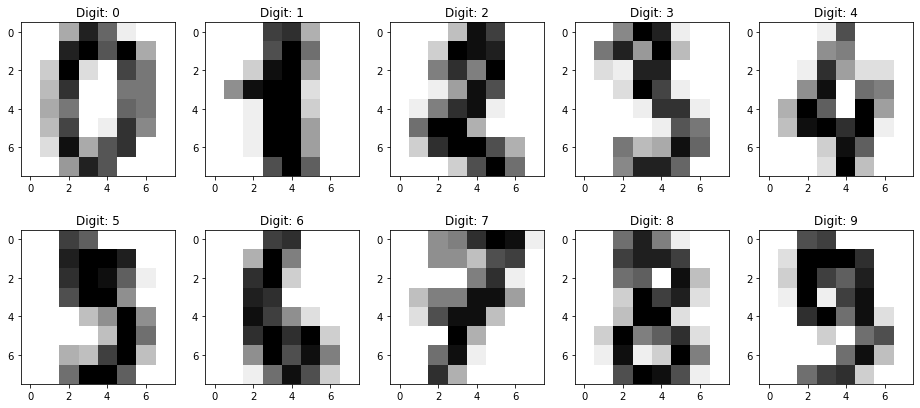

In [13]:
for i in range(0, 10):
    fig = plt.figure(1, figsize=(16, 7))
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f"Digit: {digits.target[i]}")

We are now ready to reduce the dimensions of this dataset from 64 to 2 so we can plot it.

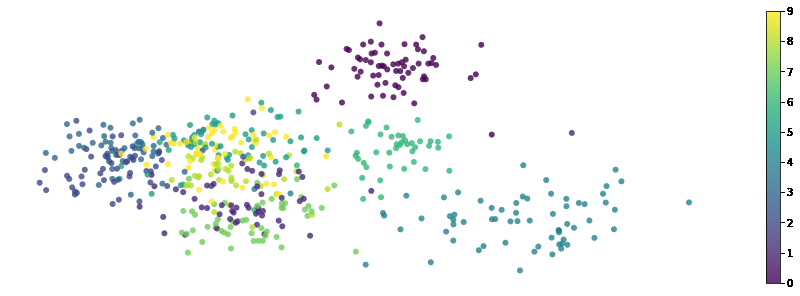

In [14]:
dfm = pd.DataFrame(columns=range(0, 65))
for i, (img, label) in enumerate(zip(digits.images.reshape(1797, 64), digits.target)):
    dfm.loc[i] = np.array([*img, label])
    
dsm = my.DataSet(dfm, y=True)

train, test = dsm.train_test_split(test_portion=.3, shuffle=True)

lda = LDA(2)
lda.fit(train)

X_projected = lda.transform(test).real
y = test.target.ravel()

fig = plt.figure(figsize=(16, 5))
plt.scatter(X_projected[:, 0], X_projected[:, 1],
        c=y, edgecolor='none', alpha=0.8)
cb = plt.colorbar()
cb.set_ticks(y)
plt.xlabel('$z_1$')
plt.ylabel('$z_1$')
plt.axis('off')
plt.show()

Let's plot by how much each discriminant (eigenvector) contributes to the total results.

Text(0.5, 0, '# of discriminant')

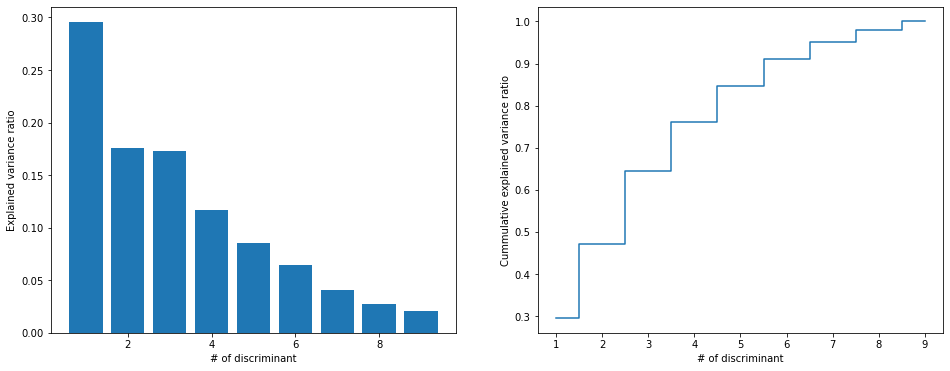

In [15]:
# Compute explained variance ratios; ignoring ratios < 0.001
expl_var = [i / lda.eig_vals.sum() for i in lda.eig_vals if i / lda.eig_vals.sum() >= 0.001] 
cum_expl_var = np.cumsum(expl_var)

fig = plt.figure(figsize=(16, 6))
ax1, ax2 = fig.subplots(1, 2)
ax1.bar(range(1, len(expl_var) + 1), expl_var, align='center')

ax1.set_ylabel('Explained variance ratio')
ax1.set_xlabel('# of discriminant')


ax2.step(range(1, len(cum_expl_var) + 1), cum_expl_var, where='mid')

ax2.set_ylabel('Cummulative explained variance ratio')
ax2.set_xlabel('# of discriminant')

## Principal Component Analysis (PCA)
This is the most commonly used dimensionality reduction technique. The main purpose of PCA is to reduce dimensions by projecting onto a line, a plane, or a hyperplane that maximizes data variability. In other words, it reduces the dimensions of the dataset with minimal loss of information. The idea of a **principal component** is the direction along which the data has largest variation.

The PCA algorithm is unsupervised, so only the input part of the dataset is used; no labels. Here are the steps of this PCA algorithm:
* Compute the $m$-dimensional mean vector $\mu$.
* Compute the covariance matrix $\Sigma$ for the whole dataset.
* Compute the eigenvalues and eigenvectors of the covariance matrix.
* Sort the eigenvectors by decreasing eigenvalues and choose the top $k$ eigenvectors as the $k$ principal components.
* Use these $k$ components to project (using the dot product) the $m$-dimensional dataset onto $k$-dimensional space where $k << m$.

Let's implement this algorithm.

In [16]:
class PCA:
    def __init__(self, ndims):
        """ ndims: how many dimensions to reduce data to"""
        self.ndims = ndims
    
    def fit(self, dataset):
        self.ds = dataset
        # Consider on the the input; no labels
        X = self.ds.inputs
        self.mu = np.mean(X, axis=0)
        
        # Center the data
        X = X - self.mu
        
        # Compute the covariance matrix
        cov = np.cov(X.T)
        
        # Compute the eigenvectors and eigenvalues of cov
        eig_vals, eig_vecs = np.linalg.eig(cov)

        # Sort eigenvectors by decreasing eigenvalues
        eig_vecs = eig_vecs.T
        sortedIndices = np.argsort(eig_vals)[::-1]
        self.eig_vals = eig_vals[sortedIndices]
        self.eig_vecs = eig_vecs[sortedIndices]

    def transform(self, unseen):
        X = unseen.inputs
        # Center the data
        X = X - self.mu
        # project the data and returing the results
        return np.dot(X, self.eig_vecs[0:self.ndims].T)

### Explained variance ratio
Given the number of components (eigenvectors) $C$, we can use the eigenvalues to calculate how much variance a single principal component $c$ explains. Like we saw before, the **explained variance ratio** is defined as:
$$\text{explained variance ratio} = \frac{\lambda_c}{\sum_{i=1}^C \lambda_i}$$

### Testing PCA with the IRIS function 

Here is an example using PCA to reduce the 4-dimensional ($x_1 - x_4$) iris dataset to 2D (($z_1 - z_2$).

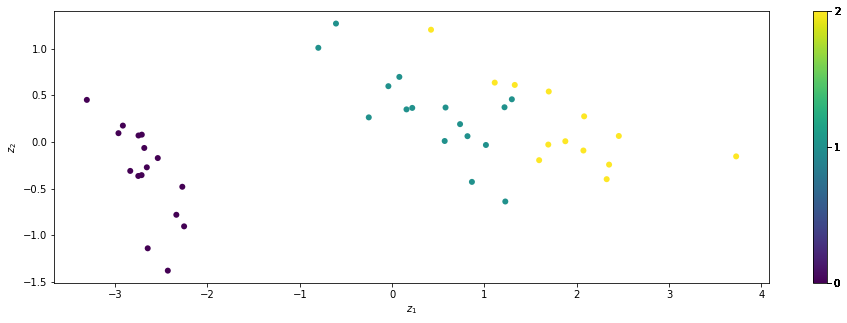

In [17]:
df = sns.load_dataset("iris")
df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: 0 if x == 'setosa' else (1 if x == 'versicolor' else 2))

ds = my.DataSet(df, y=True)
train, test = ds.train_test_split(test_portion=.3, shuffle=True)

pca = PCA(2)
pca.fit(train)

X_projected = pca.transform(test)
y = test.target.ravel()

fig = plt.figure(figsize=(16, 5))
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y, edgecolor='none')
cb = plt.colorbar()
cb.set_ticks(y)

plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.show()

Let's plot how much variance each component (eigenvector) explains.

Text(0.5, 0, '# of discriminant')

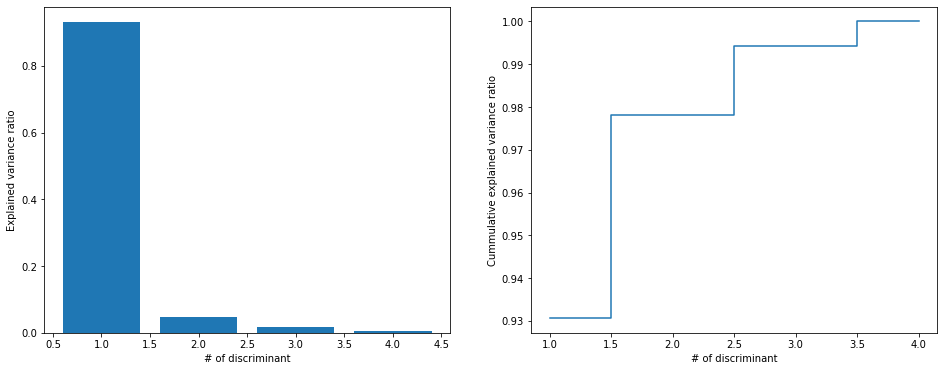

In [18]:
# Compute explained variance ratios; ignoring ratios < 0.001
expl_var = [i / pca.eig_vals.sum() for i in pca.eig_vals if i / lda.eig_vals.sum() >= 0.001] 
cum_expl_var = np.cumsum(expl_var)

fig = plt.figure(figsize=(16, 6))
ax1, ax2 = fig.subplots(1, 2)
ax1.bar(range(1, len(expl_var) + 1), expl_var, align='center')

ax1.set_ylabel('Explained variance ratio')
ax1.set_xlabel('# of discriminant')


ax2.step(range(1, len(cum_expl_var) + 1), cum_expl_var, where='mid')

ax2.set_ylabel('Cummulative explained variance ratio')
ax2.set_xlabel('# of discriminant')

### Testing PCA with the MNIST dataset
This is going to be identical to how we used LDA. Let's load the digits dataset:

In [19]:
digits = datasets.load_digits()

Let's reduce the dimensions of this dataset from 64 to 2 so we can plot it.

In [20]:
dfm = pd.DataFrame(columns=range(0, 65))
for i, (img, label) in enumerate(zip(digits.images.reshape(1797, 64), digits.target)):
    dfm.loc[i] = np.array([*img, label])
    
dsm = my.DataSet(dfm, y=True)
train, test = dsm.train_test_split(test_portion=.3, shuffle=True)

pca = PCA(2)
pca.fit(train)

X_projected = pca.transform(test)
y = test.target.ravel()

Let's plot these digits out.

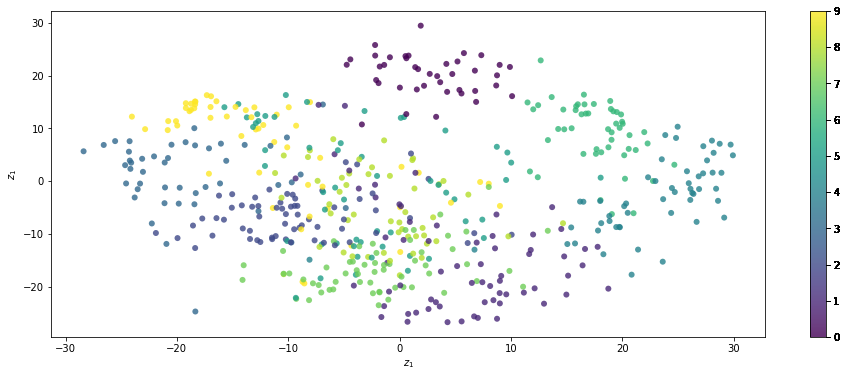

In [21]:
fig = plt.figure(figsize=(16, 6))
plt.scatter(X_projected[:, 0], X_projected[:, 1],
        c=y, edgecolor='none', alpha=0.8)
cb = plt.colorbar()
cb.set_ticks(y)
plt.xlabel('$z_1$')
plt.ylabel('$z_1$')
plt.show()

Let's plot how much variance each component (eigenvector) explains.

Text(0.5, 0, '# of discriminant')

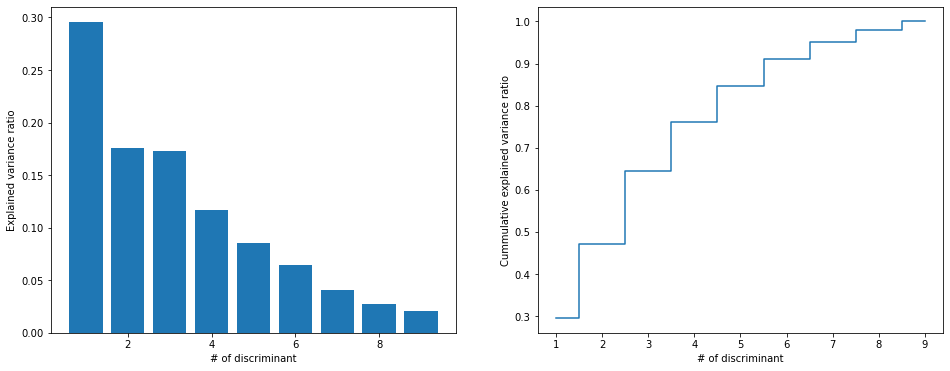

In [22]:
# Compute explained variance ratios; ignoring ratios < 0.001
expl_var = [i / lda.eig_vals.sum() for i in lda.eig_vals if i / lda.eig_vals.sum() >= 0.001] 
cum_expl_var = np.cumsum(expl_var)

fig = plt.figure(figsize=(16, 6))
ax1, ax2 = fig.subplots(1, 2)
ax1.bar(range(1, len(expl_var) + 1), expl_var, align='center')

ax1.set_ylabel('Explained variance ratio')
ax1.set_xlabel('# of discriminant')


ax2.step(range(1, len(cum_expl_var) + 1), cum_expl_var, where='mid')

ax2.set_ylabel('Cummulative explained variance ratio')
ax2.set_xlabel('# of discriminant')

### CHALLENGE C
The code below uses scikit-learn datasets to create a linearly inseparable moon-shaped dataset. Use the PCA class above to transform this dataset to a one-dimensional space (a line). Plot the results.

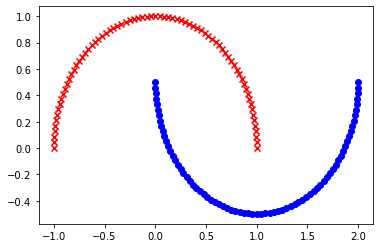

In [23]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=150, random_state=17)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='x')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o')

In [24]:
# TODO